In [88]:
from sklearn.metrics import accuracy_score
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn import preprocessing
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

In [89]:
import numpy as np
from operator import lt,ge

class DecisionStump:
    
    #A simple decision stump classifier
    
    def __init__(self, dim=0, value=0, op=lt):
        self.dim = dim
        self.value = value
        self.op = op
        
    def update(self, dim=None, value=None, op=None):
        if dim is not None: self.dim = dim
        if value is not None: self.value = value
        if op is not None: self.op = op
    
    def predict(self,X):
        return np.array([1 if self.op(x, self.value) else -1 for x in X[:,self.dim]])
    
    
    #Finding an optimal dimension and the value of that dimension which will best split
    
    def fit_data(self,X,Y,sample_weights,num_splits=100):
        n,d = X.shape
        min_err = np.inf
        
        for dim in range(d):
            #return
            min_dim_err, value, op = self.fit_dim(X[:,dim],Y,sample_weights,num_splits)
            if min_dim_err < min_err:
                min_err = min_dim_err
                self.update(dim,value,op)
       
    
    #Fit a one dimensional Decision stump classifier
    
    def fit_dim(self,X,Y,sample_weights,num_splits):

        min_err, split_value, op = np.inf, None, lt
        num_splits = min(num_splits,len(Y)-1)
        
        for value in np.linspace(min(X),max(X),num_splits,endpoint=False):
            prediction = [1 if x < value else -1 for x in X]
            indicator = np.not_equal(prediction,Y)
            Jm = np.dot(sample_weights,indicator)
            if Jm < min_err:
                min_err = Jm
                split_value = value
                op = lt
            
            Jm = np.dot(sample_weights,~indicator)
            if Jm < min_err:
                min_err = Jm
                split_value = value
                op = ge
         
        return min_err,split_value,op
        

In [90]:
class Adaboost:
    def __init__(self, weak_learners=None, learner_weights=None):
        self.weak_learners = weak_learners if weak_learners is not None else []
        self.learner_weights = learner_weights if learner_weights is not None else []
    
    def train(self, X, Y, num_classifier, weak_learner_class = DecisionStump):
        n,d = X.shape
        sample_weights = np.repeat(1/n,n);
        
        for m in range(num_classifier):
            weak_learner = weak_learner_class()
            weak_learner.fit_data(X,Y,sample_weights)
            learner_prediction = weak_learner.predict(X)
            learner_indicator = np.not_equal(learner_prediction,Y)
            learner_error = np.dot(sample_weights,learner_indicator) / np.sum(sample_weights)
            learner_error = max(1e-8,learner_error) #Avoid division by zero
            learner_weight = np.log((1-learner_error)/learner_error)
            self.weak_learners.append(weak_learner)
            self.learner_weights.append(learner_weight)
            sample_weights = [sw * np.exp(learner_weight*im) for sw,im in zip(sample_weights,learner_indicator)]
       
    def add_learner(self, X, Y, weak_learner_class = DecisionStump):
        n,d = X.shape
        sample_weights = np.repeat(1/n,n);
        
        for l,w in zip(self.weak_learners,self.learner_weights):
            learner_prediction = l.predict(X)
            learner_indicator = np.not_equal(learner_prediction,Y)
            learner_error = np.dot(sample_weights,learner_indicator) / np.sum(sample_weights)
            learner_error = max(1e-8,learner_error) #Avoid division by zero
            learner_weight = np.log((1-learner_error)/learner_error)
            
            #Update data weighting coefficient for next learner
            sample_weights = [sw * np.exp(learner_weight*im) for sw,im in zip(sample_weights,learner_indicator)]
            
        new_weak_learner = weak_learner_class()
        new_weak_learner.fit_data(X,Y,sample_weights)
        new_learner_prediction = new_weak_learner.predict(X)
        new_learner_indicator = np.not_equal(new_learner_prediction,Y)
        new_learner_error = np.dot(sample_weights,new_learner_indicator) / np.sum(sample_weights)
        new_learner_error = max(1e-8,new_learner_error) #Avoid division by zero
        new_learner_weight = np.log((1-new_learner_error)/new_learner_error)
        self.weak_learners.append(new_weak_learner)
        self.learner_weights.append(new_learner_weight)
   
    #Making predictions
    def predict(self,X):
        n,d = X.shape
        predictions = np.zeros(n)
        for l,w in zip(self.weak_learners,self.learner_weights):
            learner_prediction = l.predict(X)
            predictions += w * learner_prediction
            
        predictions = np.array([1 if p>0 else -1 for p in predictions])
        return predictions
    
    #Finding the error in making predictions
    def prediction_error(self,X,Y):
        predictions = self.predict(X)
        error = np.mean(np.not_equal(predictions,Y))
        return error
    
    #plot graph
    def plot_error_rate(er_train, er_test):
        df_error = pd.DataFrame([er_train, er_test]).T
        df_error.columns = ['Training', 'Test']
        plot1 = df_error.plot(linewidth = 3, figsize = (8,6),color = ['lightblue', 'darkblue'], grid = True)
        plot1.set_xlabel('Number of iterations', fontsize = 12)
        plot1.set_xticklabels(range(0,600,50))
        plot1.set_ylabel('Error rate', fontsize = 12)
        plot1.set_title('Error rate vs number of iterations', fontsize = 16)
        plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')
    
  
        
       

In [105]:
from sklearn.metrics import accuracy_score
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def main():
    #Read in the dataset
    datasets = pd.read_csv('wdbc_data.csv')
    Y = datasets.iloc[: ,1:2].values
    #Map labels to {-1,1}
    #Y= np.array(Y)
    Y[Y=='M']=-1
    Y[Y=='B']=1
    #Y=np.array(Y,dtype=int)
    X= datasets.iloc[: ,2:4].values
    #Y = np.array([1 if y == labels[0] else -1 for y in Y])
    new_y=[]
    for i in range(len(Y)):
        new_y.append(Y[i][0])
    Y = np.array(new_y)

    train_data = X[0:300,:]
    train_label = Y[0:300]
    test_data = X[300:,:]
    test_label = Y[300:]
    
    


    #Maximum number of weak learners to be used in Adaboost
    max_num_weak_learners = 100
    
    #Train and test error
    train_error = []
    test_error = []
    
    
    print(train_data)
    print(train_label)
    #return;
    #Training Adaboost with weak learners
    model = Adaboost()
    for m in range(1,max_num_weak_learners+1):
        print("Training Adaboost with weak learners %d" % m)
        model.add_learner(train_data,train_label)
        train_error.append(model.prediction_error(train_data,train_label))
        test_error.append(model.prediction_error(test_data,test_label))
    
    print("Initial Training Error=%.4f  Testing Error= %.4f " % (train_error[0],test_error[0]))
    print("Final Training Error=%.4f  Testing Error= %.4f " % (train_error[-1],test_error[-1])) 
    
    # Compare error rate vs number of iterations
    plot_error_rate(train_error, test_error)
    
    #sklearn_svm = svm.SVC(gamma='scale',kernel='linear')
    sklearn_svm = svm.SVC(gamma='scale',probability=True)
    sklearn_svm.fit(train_data, train_label)
    
    
    print("Accuracy score of SVM classifier : ", accuracy_score(test_label, sklearn_svm.predict(test_data)))
    
    
    abc =AdaBoostClassifier(n_estimators=100,learning_rate=1)
   
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_features=2, max_depth = 3, random_state = 0)
    model_ada = abc.fit(train_data,train_label)
    model_gradient = gb.fit(train_data,train_label)
    

    test_pred_1 = model_ada.predict(test_data)
    test_pred_2 = model_gradient.predict(test_data)
    
    print("Accuracy for AdaBoost:",metrics.accuracy_score(test_label, test_pred_1))
    print("Accuracy for GradientBoost:",metrics.accuracy_score(test_label, test_pred_2))
    



In [106]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
def roc_plot():
    datasets = pd.read_csv('wdbc_data.csv')
    Y = datasets.iloc[: ,1:2].values
    
    Y[Y=='M']=-1
    Y[Y=='B']=1
    
    X= datasets.iloc[: ,2:4].values
    
    new_y=[]
    for i in range(len(Y)):
        new_y.append(Y[i][0])
    Y = np.array(new_y)

    train_data = X[0:300,:]
    train_label = Y[0:300]
    test_data = X[300:,:]
    test_label = Y[300:]

    
    
    #gb = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_features=2, max_depth = 3, random_state = 0)
    sklearn_svm = svm.SVC(gamma='scale',probability=True)
    #probas_ = gb.fit(train_data, train_label).predict_proba(test_data)
    probas_ = sklearn_svm.fit(train_data, train_label).predict_proba(test_data)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(test_label, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('Receiver operating characteristic example')
    pl.legend(loc="lower right")
    pl.show()

[[20.57  17.77 ]
 [19.69  21.25 ]
 [11.42  20.38 ]
 [20.29  14.34 ]
 [12.45  15.7  ]
 [18.25  19.98 ]
 [13.71  20.83 ]
 [13.    21.82 ]
 [12.46  24.04 ]
 [16.02  23.24 ]
 [15.78  17.89 ]
 [19.17  24.8  ]
 [15.85  23.95 ]
 [13.73  22.61 ]
 [14.54  27.54 ]
 [14.68  20.13 ]
 [16.13  20.68 ]
 [19.81  22.15 ]
 [13.54  14.36 ]
 [13.08  15.71 ]
 [ 9.504 12.44 ]
 [15.34  14.26 ]
 [21.16  23.04 ]
 [16.65  21.38 ]
 [17.14  16.4  ]
 [14.58  21.53 ]
 [18.61  20.25 ]
 [15.3   25.27 ]
 [17.57  15.05 ]
 [18.63  25.11 ]
 [11.84  18.7  ]
 [17.02  23.98 ]
 [19.27  26.47 ]
 [16.13  17.88 ]
 [16.74  21.59 ]
 [14.25  21.72 ]
 [13.03  18.42 ]
 [14.99  25.2  ]
 [13.48  20.82 ]
 [13.44  21.58 ]
 [10.95  21.35 ]
 [19.07  24.81 ]
 [13.28  20.28 ]
 [13.17  21.81 ]
 [18.65  17.6  ]
 [ 8.196 16.84 ]
 [13.17  18.66 ]
 [12.05  14.63 ]
 [13.49  22.3  ]
 [11.76  21.6  ]
 [13.64  16.34 ]
 [11.94  18.24 ]
 [18.22  18.7  ]
 [15.1   22.02 ]
 [11.52  18.75 ]
 [19.21  18.57 ]
 [14.71  21.59 ]
 [13.05  19.31 ]
 [ 8.618 11.79

Training Adaboost with weak learners 56
Training Adaboost with weak learners 57
Training Adaboost with weak learners 58
Training Adaboost with weak learners 59
Training Adaboost with weak learners 60
Training Adaboost with weak learners 61
Training Adaboost with weak learners 62
Training Adaboost with weak learners 63
Training Adaboost with weak learners 64
Training Adaboost with weak learners 65
Training Adaboost with weak learners 66
Training Adaboost with weak learners 67
Training Adaboost with weak learners 68
Training Adaboost with weak learners 69
Training Adaboost with weak learners 70
Training Adaboost with weak learners 71
Training Adaboost with weak learners 72
Training Adaboost with weak learners 73
Training Adaboost with weak learners 74
Training Adaboost with weak learners 75
Training Adaboost with weak learners 76
Training Adaboost with weak learners 77
Training Adaboost with weak learners 78
Training Adaboost with weak learners 79
Training Adaboost with weak learners 80


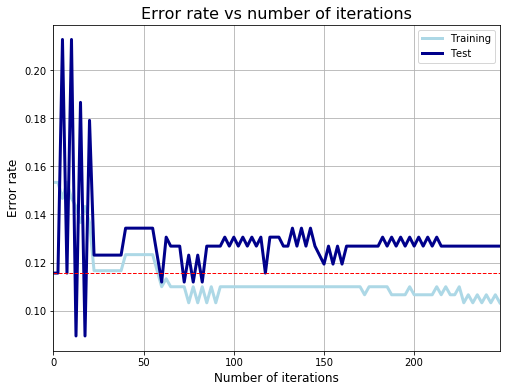

In [107]:
main()


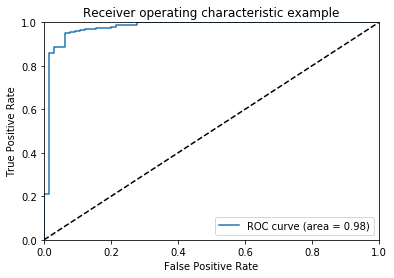

In [108]:
roc_plot()